In [1]:
import keras
from keras.models import load_model
from keras.models import model_from_json
import numpy as np
import os
from train import parse_config, get_features
from eval import makeRoc, plot_confusion_matrix
from constraints import ZeroSomeWeights
from quantized_layers import Clip, BinaryDense, TernaryDense, QuantizedDense
from models import binary_tanh, ternary_tanh, quantized_relu
import yaml
from sklearn.metrics import confusion_matrix
import tkinter
import matplotlib
matplotlib.use('TkAgg')
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [2]:
file_name = 'KERAS_1layer.json'
json_file = open(file_name, 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("KERAS_1layer_weights.h5")
print("Loaded model")

Loaded model


In [3]:
loaded_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 10)                0         
_________________________________________________________________
fc1_relu (Dense)             (None, 32)                352       
_________________________________________________________________
output_sigmoid (Dense)       (None, 1)                 33        
Total params: 385
Trainable params: 385
Non-trainable params: 0
_________________________________________________________________


In [4]:
# import yaml
# config_file = "train_config_twolayer.yml"
# config = open(config_file, 'r')
# yamlConfig = yaml.load(config, Loader=yaml.FullLoader)
# print(yamlConfig)

In [5]:
data_path = 'processed-pythia82-lhc13-all-pt1-50k-r1_h022_e0175_t220_nonu_truth.z'
            #processed-pythia82-lhc13-all-pt1-50k-r1_h022_e0175_t220_nonu_truth.z
# x,y = np.load(data_path, allow_pickle=True)
import h5py
f = h5py.File(data_path, 'r')
treeArray = f['t_allpar_new'][()]
print(treeArray.dtype.names)

('j_ptfrac', 'j_pt', 'j_eta', 'j_mass', 'j_tau1_b1', 'j_tau2_b1', 'j_tau3_b1', 'j_tau1_b2', 'j_tau2_b2', 'j_tau3_b2', 'j_tau32_b1', 'j_tau32_b2', 'j_zlogz', 'j_c1_b0', 'j_c1_b1', 'j_c1_b2', 'j_c2_b1', 'j_c2_b2', 'j_d2_b1', 'j_d2_b2', 'j_d2_a1_b1', 'j_d2_a1_b2', 'j_m2_b1', 'j_m2_b2', 'j_n2_b1', 'j_n2_b2', 'j_tau1_b1_mmdt', 'j_tau2_b1_mmdt', 'j_tau3_b1_mmdt', 'j_tau1_b2_mmdt', 'j_tau2_b2_mmdt', 'j_tau3_b2_mmdt', 'j_tau32_b1_mmdt', 'j_tau32_b2_mmdt', 'j_c1_b0_mmdt', 'j_c1_b1_mmdt', 'j_c1_b2_mmdt', 'j_c2_b1_mmdt', 'j_c2_b2_mmdt', 'j_d2_b1_mmdt', 'j_d2_b2_mmdt', 'j_d2_a1_b1_mmdt', 'j_d2_a1_b2_mmdt', 'j_m2_b1_mmdt', 'j_m2_b2_mmdt', 'j_n2_b1_mmdt', 'j_n2_b2_mmdt', 'j_mass_trim', 'j_mass_mmdt', 'j_mass_prun', 'j_mass_sdb2', 'j_mass_sdm1', 'j_multiplicity', 'j_g', 'j_q', 'j_w', 'j_z', 'j_t', 'j_undef')


In [6]:
from collections import namedtuple
import sys
N = namedtuple("options", "inputModel inputFile tree config jsonModel")
options = N(
    inputModel = 'KERAS_1layer_weights.h5',
    inputFile = 'processed-pythia82-lhc13-all-pt1-50k-r1_h022_e0175_t220_nonu_truth.z',
    tree = 't_allpar_new',
    config = 'train_config_twolayer.yml',
    jsonModel = 'KERAS_1layer.json'
)

In [7]:
config = open(options.config, 'r')
yamlConfig =  yaml.load(config, Loader=yaml.FullLoader)
print(yamlConfig)

{'Inputs': ['j_zlogz', 'j_c1_b0_mmdt', 'j_c1_b1_mmdt', 'j_c2_b1_mmdt', 'j_d2_b1_mmdt', 'j_d2_a1_b1_mmdt', 'j_m2_b1_mmdt', 'j_n2_b1_mmdt', 'j_mass_mmdt', 'j_multiplicity'], 'Labels': ['j_t'], 'KerasModel': 'two_layer_model', 'KerasModelRetrain': 'two_layer_model_constraint', 'KerasLoss': 'binary_crossentropy', 'L1Reg': 0, 'NormalizeInputs': 0, 'ConvInputs': 0, 'InputType': 'Dense'}


In [8]:
X_train_val, X_test, y_train_val, y_test, labels  = get_features(options, yamlConfig)

(986806,)

/Users/butterchicken/research/testingMLmodels/train.py:33: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  h5File = h5py.File(options.inputFile)



('j_ptfrac', 'j_pt', 'j_eta', 'j_mass', 'j_tau1_b1', 'j_tau2_b1', 'j_tau3_b1', 'j_tau1_b2', 'j_tau2_b2', 'j_tau3_b2', 'j_tau32_b1', 'j_tau32_b2', 'j_zlogz', 'j_c1_b0', 'j_c1_b1', 'j_c1_b2', 'j_c2_b1', 'j_c2_b2', 'j_d2_b1', 'j_d2_b2', 'j_d2_a1_b1', 'j_d2_a1_b2', 'j_m2_b1', 'j_m2_b2', 'j_n2_b1', 'j_n2_b2', 'j_tau1_b1_mmdt', 'j_tau2_b1_mmdt', 'j_tau3_b1_mmdt', 'j_tau1_b2_mmdt', 'j_tau2_b2_mmdt', 'j_tau3_b2_mmdt', 'j_tau32_b1_mmdt', 'j_tau32_b2_mmdt', 'j_c1_b0_mmdt', 'j_c1_b1_mmdt', 'j_c1_b2_mmdt', 'j_c2_b1_mmdt', 'j_c2_b2_mmdt', 'j_d2_b1_mmdt', 'j_d2_b2_mmdt', 'j_d2_a1_b1_mmdt', 'j_d2_a1_b2_mmdt', 'j_m2_b1_mmdt', 'j_m2_b2_mmdt', 'j_n2_b1_mmdt', 'j_n2_b2_mmdt', 'j_mass_trim', 'j_mass_mmdt', 'j_mass_prun', 'j_mass_sdb2', 'j_mass_sdm1', 'j_multiplicity', 'j_g', 'j_q', 'j_w', 'j_z', 'j_t', 'j_undef')


In [9]:
json_file = open(options.jsonModel, 'r')
model = json_file.read()
json_file.close()
model = model_from_json(model, custom_objects={'ZeroSomeWeights': ZeroSomeWeights,
                                                           'BinaryDense': BinaryDense,
                                                           'TernaryDense': TernaryDense,
                                                           'QuantizedDense': QuantizedDense,
                                                           'binary_tanh': binary_tanh,
                                                           'ternary_tanh': ternary_tanh,
                                                           'quantized_relu': quantized_relu,
                                                           'Clip': Clip})

In [10]:
model.load_weights(options.inputModel)
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 10)                0         
_________________________________________________________________
fc1_relu (Dense)             (None, 32)                352       
_________________________________________________________________
output_sigmoid (Dense)       (None, 1)                 33        
Total params: 385
Trainable params: 385
Non-trainable params: 0
_________________________________________________________________


Plot ROC curve
in makeRoc()


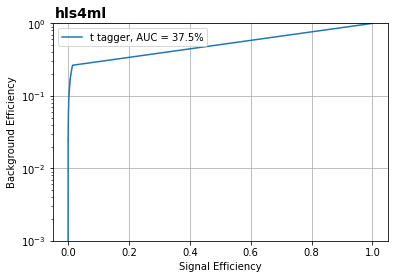

Plot confusion matrix


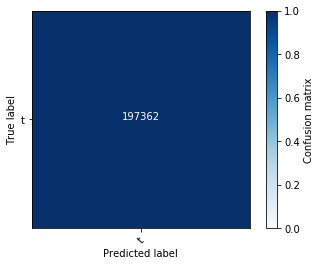

Plot normalized confusion matrix


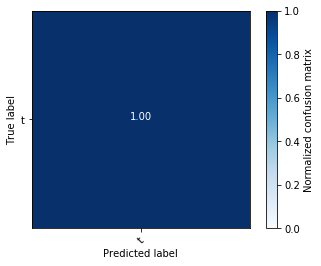

In [11]:
print("Plot ROC curve")
y_predict = makeRoc(X_test, labels, y_test, model)
plt.show()
# print(y_predict)

y_test_proba = y_test.argmax(axis=1)
y_predict_proba = y_predict.argmax(axis=1)

print("Plot confusion matrix")
# Compute non-normalized confusion matrix
cnf_matrix = confusion_matrix(y_test_proba, y_predict_proba)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=[l.replace('j_','') for l in labels],
                          title='Confusion matrix')
# plt.show()
print("Plot normalized confusion matrix")

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=[l.replace('j_','') for l in labels], normalize=True,
                          title='Normalized confusion matrix')
# plt.show()